<a href="https://colab.research.google.com/github/Nickchiu120026/2025_machine_learning/blob/main/homework3_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Config(n_train=256, n_val=128, sampling='uniform', noise_std=0.0, hidden_sizes=(64, 64), act='tanh', lr=0.001, l2=1e-06, batch_size=128, epochs=5000, patience=150, lambda_deriv=0.1, use_scheduler=True, smooth_loss_for_plot=True, smooth_factor=0.9)
Epoch    1 | train_total=4.034151e-01 (f=2.407592e-01, df=1.626559e+00) | val_total=2.636150e-01 (f=1.095595e-01, df=1.540554e+00)
Epoch  200 | train_total=2.639912e-04 (f=1.543449e-05, df=2.485567e-03) | val_total=3.820921e-04 (f=1.788425e-05, df=3.642078e-03)
Epoch  400 | train_total=1.615368e-05 (f=7.563777e-07, df=1.539731e-04) | val_total=2.020530e-05 (f=6.981425e-07, df=1.950715e-04)
Epoch  600 | train_total=5.577205e-06 (f=2.045240e-07, df=5.372681e-05) | val_total=6.179260e-06 (f=1.444179e-07, df=6.034843e-05)
Epoch  800 | train_total=2.719372e-06 (f=5.988764e-08, df=2.659485e-05) | val_total=3.212877e-06 (f=4.808679e-08, df=3.164791e-05)
Epoch 1000 | train_total=1.711362e-06 (f=2.163107e-08, df=1.689731e-05) | val_t

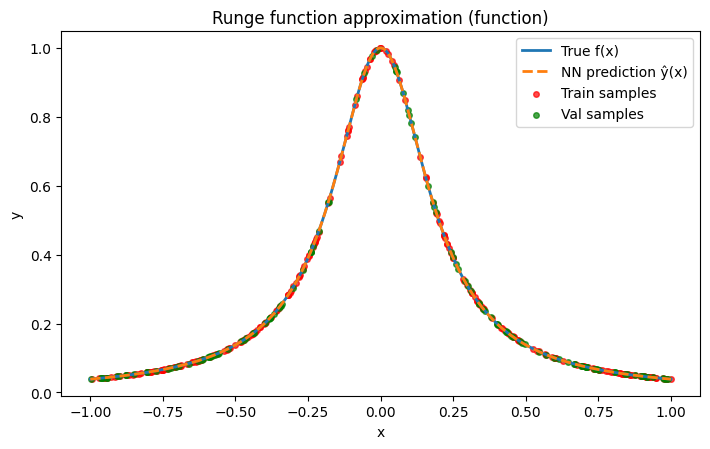

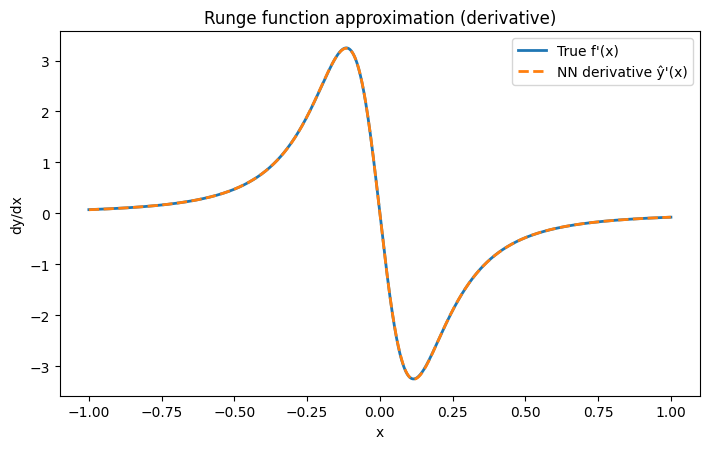

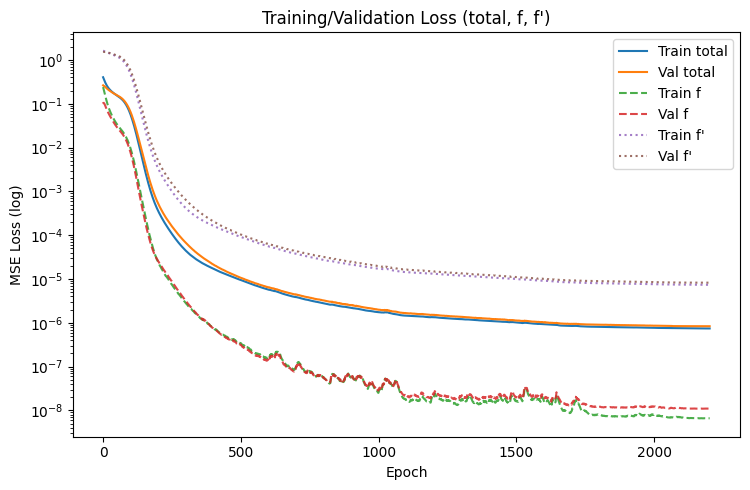


Suggested report bullets:
- Model: MLP (64, 64) with tanh activation | Adam lr=0.001, L2=1e-06, batch=128, λ_deriv=0.1
- Data: uniform sampling | train=256, val=128 | noise_std=0.0
- Early stopping best val_total ≈ 8.231010e-07
- Function:   MSE=1.03552455e-08,  MaxErr=4.02331352e-04
- Derivative: MSE=9.53159815e-06, MaxErr=1.16710663e-02
- Figures: "fig_f_fit.png", "fig_df_fit.png", "fig_losses.png"


In [6]:
# ==============================================================
# Assignment 3 (Final, Colab-ready)
# Learn f(x) and f'(x) for the Runge function with a joint loss
# ==============================================================

import random, math
from dataclasses import dataclass
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# -----------------------------
# 0) Reproducibility & device
# -----------------------------
SEED = 2025
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 1) Problem definition
# -----------------------------
def f_runge(x: np.ndarray) -> np.ndarray:
    """f(x) = 1 / (1 + 25 x^2)"""
    return 1.0 / (1.0 + 25.0 * x**2)

def df_runge(x: np.ndarray) -> np.ndarray:
    """f'(x) = -50x / (1 + 25x^2)^2"""
    return (-50.0 * x) / (1.0 + 25.0 * x**2) ** 2

# -----------------------------
# 2) Config
# -----------------------------
@dataclass
class Config:
    # data
    n_train: int = 256
    n_val: int = 128
    sampling: str = "uniform"     # "uniform" or "chebyshev"
    noise_std: float = 0.0
    # model & optim
    hidden_sizes: tuple = (64, 64)
    act: str = "tanh"             # "tanh" or "relu"
    lr: float = 1e-3
    l2: float = 1e-6
    batch_size: int = 128
    epochs: int = 5000
    patience: int = 150           # early stop on val_total
    lambda_deriv: float = 0.1     # weight for derivative loss
    use_scheduler: bool = True
    # plotting
    smooth_loss_for_plot: bool = True
    smooth_factor: float = 0.9

cfg = Config()
print(cfg)

# -----------------------------
# 3) Data generation
# -----------------------------
def chebyshev_nodes(n: int) -> np.ndarray:
    k = np.arange(1, n+1)
    x = np.cos((2*k - 1) * np.pi / (2*n))
    return x.astype(np.float32).reshape(-1, 1)

def uniform_nodes(n: int) -> np.ndarray:
    return np.random.uniform(-1.0, 1.0, size=(n, 1)).astype(np.float32)

def make_split(n_train, n_val, sampling="uniform", noise_std=0.0):
    if sampling == "chebyshev":
        x_train = chebyshev_nodes(n_train)
        x_val   = chebyshev_nodes(n_val)
    else:
        x_train = uniform_nodes(n_train)
        x_val   = uniform_nodes(n_val)

    y_train  = f_runge(x_train).astype(np.float32)
    dy_train = df_runge(x_train).astype(np.float32)
    if noise_std > 0:
        y_train += noise_std * np.random.randn(*y_train.shape).astype(np.float32)

    y_val  = f_runge(x_val).astype(np.float32)
    dy_val = df_runge(x_val).astype(np.float32)

    return (torch.from_numpy(x_train), torch.from_numpy(y_train), torch.from_numpy(dy_train)), \
           (torch.from_numpy(x_val),   torch.from_numpy(y_val),   torch.from_numpy(dy_val))

(train_x, train_y, train_dy), (val_x, val_y, val_dy) = make_split(
    cfg.n_train, cfg.n_val, cfg.sampling, cfg.noise_std
)
train_ds = TensorDataset(train_x, train_y, train_dy)
val_ds   = TensorDataset(val_x,   val_y,   val_dy)
train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False)

# -----------------------------
# 4) Model
# -----------------------------
def make_mlp(in_dim=1, hidden=(64,64), act="tanh"):
    Act = nn.Tanh if act.lower() == "tanh" else nn.ReLU
    layers, last = [], in_dim
    for h in hidden:
        layers += [nn.Linear(last, h), Act()]
        last = h
    layers += [nn.Linear(last, 1)]
    return nn.Sequential(*layers)

model = make_mlp(hidden=cfg.hidden_sizes, act=cfg.act).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.l2)
if cfg.use_scheduler:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                                           factor=0.5, patience=40)

# -----------------------------
# 5) Utilities
# -----------------------------
def predict_and_grad(model, x, create_graph: bool):
    """
    Return y_hat and dy_hat = d y_hat / d x.
    Make x a fresh leaf tensor to avoid 'backward through the graph a second time'.
    """
    x = x.detach().clone().requires_grad_(True)   # fresh leaf
    y_hat = model(x)
    # scalarize to avoid grad_outputs and keep graph if training
    (dy_hat,) = torch.autograd.grad(
        y_hat.sum(), x, create_graph=create_graph, retain_graph=True, only_inputs=True
    )
    return y_hat, dy_hat

def smooth_curve(values, factor=0.9):
    if not values: return values
    out, last = [], values[0]
    for v in values:
        last = last * factor + (1 - factor) * v
        out.append(last)
    return out

# -----------------------------
# 6) Train loop
# -----------------------------
best_val_total = float("inf")
best_state = None
patience_left = cfg.patience

hist = {"train_total":[], "val_total":[],
        "train_f":[], "val_f":[],
        "train_df":[], "val_df":[]}

for epoch in range(1, cfg.epochs + 1):
    # ---- Train ----
    model.train()
    t_total = t_f = t_df = 0.0

    for xb, yb, dyb in train_loader:
        xb = xb.to(device); yb = yb.to(device); dyb = dyb.to(device)

        y_hat, dy_hat = predict_and_grad(model, xb, create_graph=True)

        f_loss  = criterion(y_hat,  yb)
        df_loss = criterion(dy_hat, dyb)
        total_loss = f_loss + cfg.lambda_deriv * df_loss

        optimizer.zero_grad(set_to_none=True)
        total_loss.backward()            # 單次 backward，別再對其他 loss 另做 backward
        optimizer.step()

        t_total += total_loss.item() * xb.size(0)
        t_f     += f_loss.item()        * xb.size(0)
        t_df    += df_loss.item()       * xb.size(0)

    train_total = t_total / len(train_ds)
    train_f     = t_f     / len(train_ds)
    train_df    = t_df    / len(train_ds)
    hist["train_total"].append(train_total)
    hist["train_f"].append(train_f)
    hist["train_df"].append(train_df)

    # ---- Validate ----
    model.eval()
    v_total = v_f = v_df = 0.0

    for xb, yb, dyb in val_loader:
        xb = xb.to(device); yb = yb.to(device); dyb = dyb.to(device)

        # function loss 不建圖
        with torch.no_grad():
            y_hat = model(xb)
            f_loss = criterion(y_hat, yb)

        # derivative loss 需要 wrt x 的梯度，暫時開啟 grad，但不 backward
        with torch.enable_grad():
            x_tmp = xb.detach().clone().requires_grad_(True)
            y_hat_val = model(x_tmp)
            (dy_hat,) = torch.autograd.grad(y_hat_val.sum(), x_tmp, create_graph=False, retain_graph=False)
            df_loss = criterion(dy_hat, dyb)

        total_loss = f_loss + cfg.lambda_deriv * df_loss
        v_total += total_loss.item() * xb.size(0)
        v_f     += f_loss.item()     * xb.size(0)
        v_df    += df_loss.item()    * xb.size(0)

    val_total = v_total / len(val_ds)
    val_f     = v_f     / len(val_ds)
    val_df    = v_df    / len(val_ds)
    hist["val_total"].append(val_total)
    hist["val_f"].append(val_f)
    hist["val_df"].append(val_df)

    if cfg.use_scheduler:
        scheduler.step(val_total)

    # early stopping on total val loss
    if val_total + 1e-12 < best_val_total:
        best_val_total = val_total
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        patience_left = cfg.patience
    else:
        patience_left -= 1

    if epoch % 200 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d} | "
              f"train_total={train_total:.6e} (f={train_f:.6e}, df={train_df:.6e}) | "
              f"val_total={val_total:.6e} (f={val_f:.6e}, df={val_df:.6e})")

    if patience_left <= 0:
        print(f"Early stopping at epoch {epoch} | best val_total={best_val_total:.6e}")
        break

# load best weights
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

# -----------------------------
# 7) Dense evaluation & metrics
# -----------------------------
xs = np.linspace(-1.0, 1.0, 1000, dtype=np.float32).reshape(-1, 1)
ys  = f_runge(xs)
dys = df_runge(xs)

with torch.no_grad():
    xg = torch.from_numpy(xs).to(device)
    y_hat_grid = model(xg).cpu().numpy()

with torch.enable_grad():
    xg2 = torch.from_numpy(xs).to(device).detach().clone().requires_grad_(True)
    y_hat2 = model(xg2)
    (dy_hat_grid,) = torch.autograd.grad(y_hat2.sum(), xg2, create_graph=False, retain_graph=False)
    dy_hat_grid = dy_hat_grid.cpu().numpy()

mse_f   = float(np.mean((y_hat_grid - ys)**2))
maxe_f  = float(np.max(np.abs(y_hat_grid - ys)))
mse_df  = float(np.mean((dy_hat_grid - dys)**2))
maxe_df = float(np.max(np.abs(dy_hat_grid - dys)))

print("\n== Final metrics on dense grid ==")
print(f"Function     MSE: {mse_f:.8e} | Max Error: {maxe_f:.8e}")
print(f"Derivative   MSE: {mse_df:.8e} | Max Error: {maxe_df:.8e}")

# -----------------------------
# 8) Plots
# -----------------------------
# a) f vs f_hat (+ samples)
plt.figure(figsize=(7.2,4.6))
plt.plot(xs, ys, label="True f(x)", linewidth=2)
plt.plot(xs, y_hat_grid, "--", label="NN prediction ŷ(x)", linewidth=2)
plt.scatter(train_x.numpy(), train_y.numpy(), s=16, alpha=0.7, c="red",   label="Train samples")
plt.scatter(val_x.numpy(),   val_y.numpy(),   s=16, alpha=0.7, c="green", label="Val samples")
plt.title("Runge function approximation (function)")
plt.xlabel("x"); plt.ylabel("y"); plt.legend()
plt.tight_layout(); plt.savefig("fig_f_fit.png", dpi=160); plt.show()

# b) f' vs f'_hat
plt.figure(figsize=(7.2,4.6))
plt.plot(xs, dys, label="True f'(x)", linewidth=2)
plt.plot(xs, dy_hat_grid, "--", label="NN derivative ŷ'(x)", linewidth=2)
plt.title("Runge function approximation (derivative)")
plt.xlabel("x"); plt.ylabel("dy/dx"); plt.legend()
plt.tight_layout(); plt.savefig("fig_df_fit.png", dpi=160); plt.show()

# c) Loss curves (log-scale) – total + components
def maybe_smooth(v):
    return smooth_curve(v, cfg.smooth_factor) if cfg.smooth_loss_for_plot else v

plt.figure(figsize=(7.6,5.0))
plt.plot(maybe_smooth(hist["train_total"]), label="Train total")
plt.plot(maybe_smooth(hist["val_total"]),   label="Val total")
plt.plot(maybe_smooth(hist["train_f"]),     "--", alpha=0.85, label="Train f")
plt.plot(maybe_smooth(hist["val_f"]),       "--", alpha=0.85, label="Val f")
plt.plot(maybe_smooth(hist["train_df"]),    ":",  alpha=0.85, label="Train f'")
plt.plot(maybe_smooth(hist["val_df"]),      ":",  alpha=0.85, label="Val f'")
plt.yscale("log")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss (log)")
plt.title("Training/Validation Loss (total, f, f')")
plt.legend()
plt.tight_layout(); plt.savefig("fig_losses.png", dpi=160); plt.show()

# -----------------------------
# 9) Report bullets
# -----------------------------
print("\nSuggested report bullets:")
print(f"- Model: MLP {cfg.hidden_sizes} with {cfg.act} activation | Adam lr={cfg.lr}, L2={cfg.l2}, "
      f"batch={cfg.batch_size}, λ_deriv={cfg.lambda_deriv}")
print(f"- Data: {cfg.sampling} sampling | train={cfg.n_train}, val={cfg.n_val} | noise_std={cfg.noise_std}")
print(f"- Early stopping best val_total ≈ {best_val_total:.6e}")
print(f"- Function:   MSE={mse_f:.8e},  MaxErr={maxe_f:.8e}")
print(f"- Derivative: MSE={mse_df:.8e}, MaxErr={maxe_df:.8e}")
print('- Figures: "fig_f_fit.png", "fig_df_fit.png", "fig_losses.png"')
